# In-Class Assignment 5 - Classification

## Some Examples of Classification Problems
1. Is an email spam?
2. Will a person default on their loan?
3. What type of cancer does a person have?
3. Will the weather tomorrow be sunny, cloudy with no rain, or cloudy with rain?

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from sklearn.model_selection import train_test_split
import scipy.stats as ss
import seaborn as sns
from itertools import product


from ISLP import load_data
default_data = load_data('Default')
default_data

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


### We need to code the data as 0-1 (dummy variables) for our categorical columns

In [199]:
default_data = pd.get_dummies(default_data, columns=['default', 'student'], drop_first=True)
for col in ['default_Yes', 'student_Yes']:
    default_data[col] = default_data[col].astype(int)

In [200]:
default_data.corr(numeric_only=True)

,balance,income,default_Yes,student_Yes
balance,1.000000,-0.152243,0.350119,0.203578
income,-0.152243,1.000000,-0.019871,-0.753985
default_Yes,0.350119,-0.019871,1.000000,0.035420
student_Yes,0.203578,-0.753985,0.035420,1.000000


<Axes: title={'center': 'balance'}, xlabel='default_Yes'>

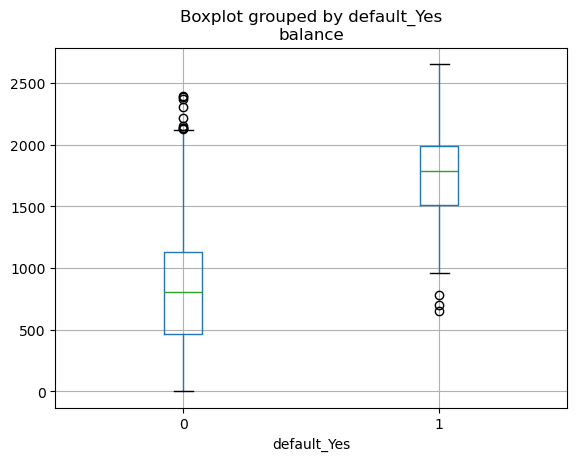

In [201]:
# default_data['color'] = default_data['default'].apply(lambda x: 'red' if x == 'Yes' else 'lightgreen')
# default_data.plot.scatter(x='balance', y='income', c=default_data['color'], alpha=.5)
default_data.boxplot(column=['balance'], by='default_Yes')

<Axes: title={'center': 'income'}, xlabel='default_Yes'>

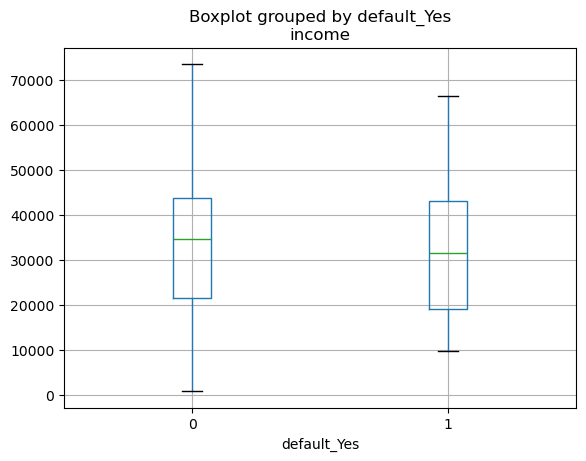

In [202]:
default_data.boxplot(column=['income'], by='default_Yes')

## Why don't we just fit a linear regression model?
* Actually, when the outcome has only two levels, the predictions are an approximation of the probability of an outcome. 
* What do we do if there is more than one level?
* Will the predictions fall in a probability space?

In [203]:
model = ols(f"default_Yes ~ balance + income + student_Yes", data=default_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            default_Yes   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     471.7
Date:                Wed, 18 Sep 2024   Prob (F-statistic):          1.09e-286
Time:                        13:35:09   Log-Likelihood:                 3653.0
No. Observations:               10000   AIC:                            -7298.
Df Residuals:                    9996   BIC:                            -7269.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0812      0.008     -9.685      0.000      -0.098      -0.065
balance         0.0001   3.55e-06     37.412      0.000       0.000       0.000
income       1.992e-07   1.92e-07      1.039      0.299   -1.77e-07    5.75e-07
student_Yes    -0.0103      0.006     -1.824      0.068      -0.021       0.001
==============================================================================
Omnibus:                     8530.277   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           179496.439
Skew:                           4.231   Prob(JB):                         0.00
Kurtosis:                      21.952   Cond. No.                     2.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='balance', ylabel='default_Yes'>

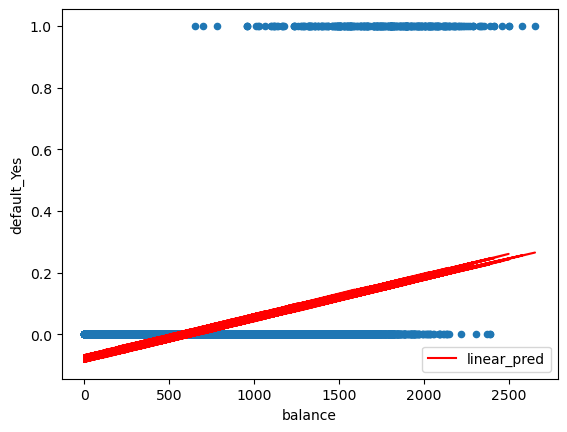

In [204]:
default_data['linear_pred'] = results.predict(default_data[['balance', 'income', 'student_Yes']])
fig, ax = plt.subplots()
default_data.plot.scatter(x='balance', y='default_Yes', ax=ax)
default_data.plot(x='balance', y='linear_pred', ax=ax, c='red')

## Why are there two lines?
* Any dummy variable in a linear model will induce another line...

## The logit model
* We want to predict the probability that our independent varibles lead to a certain class. 
    * Then, we can either choose to make a prediction based on the most likely class, or we can set our own rule, e.g. any defualt probability greater than .2
* The linear regression approach leads to the model $p(X) = \beta_0 + \beta_1 X$.


* The logit model uses the logistic function: 
\begin{equation}
p(X) = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}}.
\end{equation}

* From this, we have 
\begin{equation}
\frac{p(X)}{(1 - p(X))} = e^{\beta_0 + \beta_1 X},
\end{equation}
which we call the *odds* or the probability of occurence divided by the probability of non-occurence. Taking the log of this we get
\begin{equation}
log \left(\frac{p(X)}{1 - p(X)} \right) = \beta_0 + \beta_1 X.
\end{equation}

### How do we estimate the coefficients?
* As usual, we can use any valid optimization method, but in this case, we are not minizing the error, we are maximizing the *likelihood function*:
\begin{equation}
l(\beta_0, \beta_1) = \Pi_{i: y_i = 1} p(x_i) \Pi_{i: y_i = 0} (1 - p(x_i)).
\end{equation}

In [205]:
model = logit(f"default_Yes ~ balance + income + student_Yes", data=default_data)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                  0.4619
Time:                        13:35:10   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance         0.0057      0.000     24.737      0.000       0.005       0.006
income       3.033e-06    8.2e-06      0.370      0.712    -1.3e-05    1.91e-05
student_Yes    -0.6468      0.236     -2.738      0.006      -1.110      -0.184
===============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## We've got some new outputs here.
* Pay attention to:
    * converged -- did the optimization method converge
    * psuedo R-squared -- amount of improvement in likelihood function from fitted model vs null model (see Log-likelihood and Log-Likelihood null), where null has only the intercept
    * LLR p-value calculated from the $\chi^2$ distribution where the statistic is $2 (LLF - LLNull)$
    * We use $z$ instead of $t$ because it is the appropriate statistic for likelihood based functions, but the interpretation for the null hypothesis is the same.
    * Coefficients must be interpreted differently than linear regression, because of our objective function:
        * a one unit increase in a predictor variable with index $j$ is associated with a $\beta_j$ change in the log odds of the outcome, *keeping all other variables fixed*.
        * the positive and negative nature of the coefficient can be thought of as positive and negative changes in the probability of the outcome, but remember that this is not the precise definition. 


<Axes: xlabel='balance', ylabel='logistic_pred'>

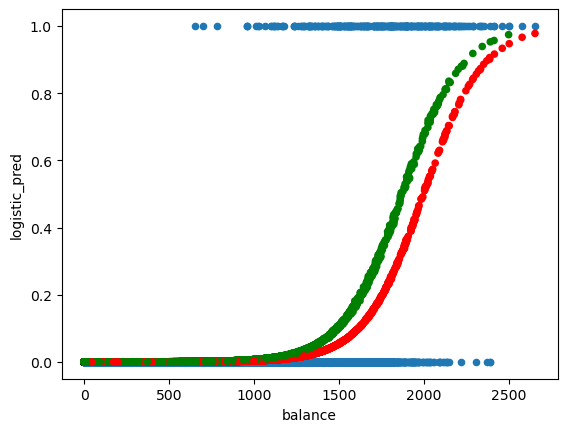

In [206]:
default_data['logistic_pred'] = results.predict(default_data[['balance', 'income', 'student_Yes']])
fig, ax = plt.subplots()
default_data.plot.scatter(x='balance', y='default_Yes', ax=ax)

default_data['color'] = default_data['student_Yes'].apply(lambda x: 'red' if x==1 else 'green')
default_data.plot.scatter(x='balance', y='logistic_pred', ax=ax, c=default_data['color'])

## Prediction classes
* We can make predictions from probabilities (sometimes called scores), by selecting a threshold, e.g. if we set the threshold to .5, we predict default if the predicted probability of default is greater than .5
* We can then calculate the accuracy, true positive, false positive, true negative, and false negatives

linear_pred accuracy: 0.9667
logistic_pred accuracy: 0.9732


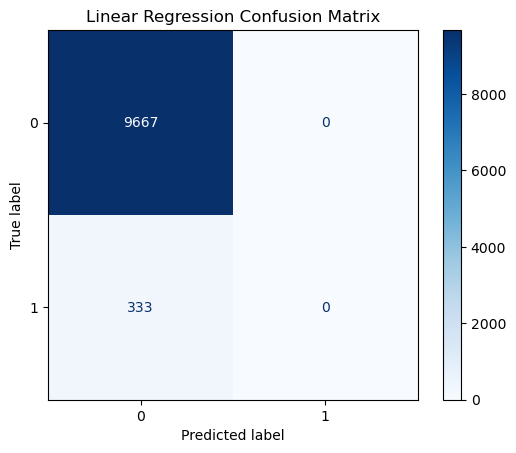

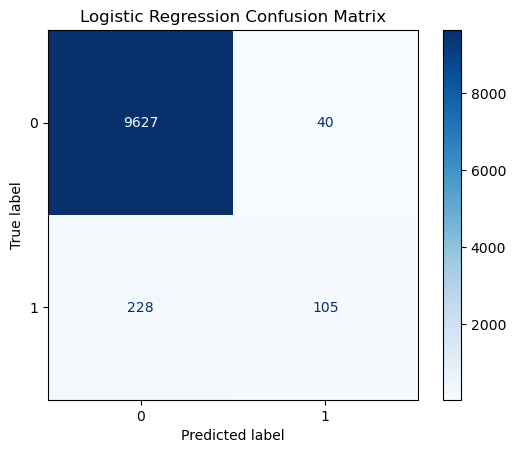

In [211]:
def get_confusion_matrices(threshold):
    for col in ['linear_pred', 'logistic_pred']:
        default_data[f'{col}_default'] = (default_data[col] > threshold).astype(int)
        default_data[f'{col}_correct'] = (default_data[f'{col}_default'] == default_data['default_Yes']).astype(int)
        print(col, "accuracy:", default_data[f'{col}_correct'].mean())

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm  = confusion_matrix(default_data['default_Yes'], default_data['linear_pred_default'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Linear Regression Confusion Matrix')
    plt.show()

    cm  = confusion_matrix(default_data['default_Yes'], default_data['logistic_pred_default'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Logistic Regression Confusion Matrix')
    plt.show()

threshold = .5
get_confusion_matrices(threshold)

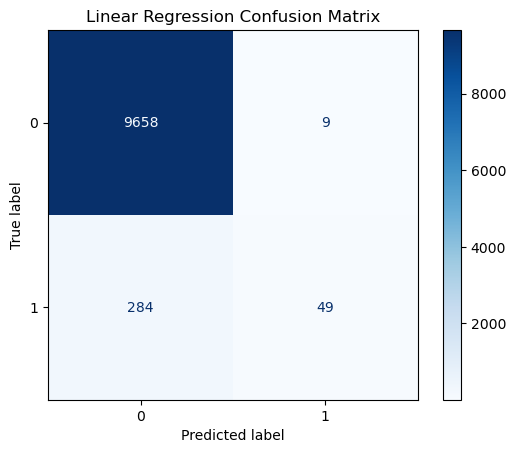

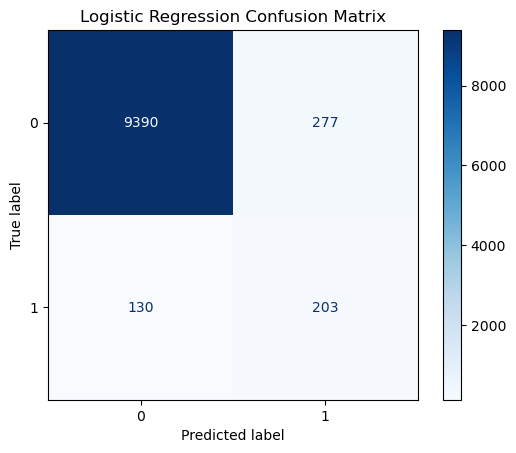

In [208]:
threshold = .2
get_confusion_matrices(threshold)

## Changing thresholds changes the behavior of the same predictor, how can we summarize results over all possible thresholds?
* the ROC curve does this
    * as seen below the curve is plotted on values of true and false positives
    * a ``good'' curve hugs the upper left hand corner, meaning we don't need to get a large rate false positives to get a large rate of true positives
* the area under the curve is another measure of the fit of our model

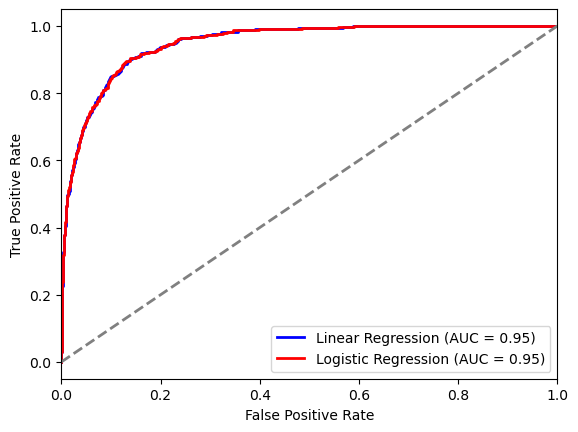

In [209]:
from sklearn.metrics import roc_auc_score, roc_curve


# ROC curve and AUC for linear regression
fpr_linear, tpr_linear, _ = roc_curve(default_data['default_Yes'], default_data['linear_pred'])
auc_linear = roc_auc_score(default_data['default_Yes'], default_data['linear_pred'])

# ROC curve and AUC for logistic regression
fpr_logistic, tpr_logistic, _ = roc_curve(default_data['default_Yes'], default_data['logistic_pred'])
auc_logistic = roc_auc_score(default_data['default_Yes'], default_data['logistic_pred'])

# Plot ROC curves
plt.figure()
plt.plot(fpr_linear, tpr_linear, color='blue', lw=2, label=f'Linear Regression (AUC = {auc_linear:.2f})')
plt.plot(fpr_logistic, tpr_logistic, color='red', lw=2, label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Multinomial Regression
* We fit the model in the same way, but now, the predicted proabilities are of the sort $Pr(Y = k | X = x)$, where $k > 2$.
* As usual with dummy variables, we must decide which case serves as the baseline (the all zero category).
* Let that class be the $K^{th}$ class, then we have
\begin{equation}
Pr(Y = k | X = x) = \frac{e^{\beta_{k, 0} + \beta_{k, 1} + ... + \beta_{k, p}}}{1 + \sum_{l=1}^{K - 1} e^{\beta_{l, 0} + \beta_{l, 1} + ... + \beta_{l, p}}},
\end{equation}
therefore we have
\begin{equation}
Pr(Y = K | X = x) = \frac{1}{1 + \sum_{l=1}^{K - 1} e^{\beta_{l, 0} + \beta_{l, 1} + ... + \beta_{l, p}}},
\end{equation}
and 
\begin{equation}
log \left( \frac{Pr(Y = k | X = x)}{Pr(Y = K | X = x)} \right) = \beta_{k, 0} + \beta_{k, 1} + ... + \beta_{k, p}.
\end{equation}

* This specification of a baseline is important, because now the interpretation of the coefficient is relative to the baseline, i.e. a one unit increase in a variable $j$ is now interpreted as a $j$ increase in the log odds of class $k$ over the baseline class or 
\begin{equation}
\frac{Pr(Y = k | X = x)}{Pr(Y = K | X = x)}
\end{equation}
increases by $e^{\beta_{k, j}}$.

# Questions
1. Based on AUC, which of these models is a better fit for our data?
* Answer:

2. At a prediction threshold of .5, what is are the true positive and false positive rates of our model? Which is more dangerous for a bank trying to predict default?
* Answer: